Topic:        Challenge Set 1  
Subject:      Explore MTA turnstile data  
Date:         01/17/2018  
Name:         Christine Liu  


#### Data Issues
* Problems with 4 hour interval refreshing
* Sometimes turnstile doesn’t give a reading
* Sometimes turnstile spazzes out
* Entries and Exits are cumalative, turnstile refreshes randomly
* Exits counting sometimes decreases and/or resets
* Duplictaed rows
* Consecutive readigs are not always 4 hours apart
* Readings does not happen alaways at the same hour across SCP
* (x)LINENAME has inconsistent ordering (i.e. NQRW123 and 123NQRW are both present) 
* (x)Columns names have spaces

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sys
%matplotlib inline

### Challenge 1
* Open up a new IPython notebook
* Download a few MTA turnstile data files
* Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row. For example, one key-value pair should look like


{ ('A002','R051','02-00-00','LEXINGTON AVE'): [ ['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'], ['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'], ['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'], ... ] }

In [2]:
x = ['180113', '180106']

def get_mydata(data_dates):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    all_dfs = []
    for i in data_dates:
        file_url = url.format(i)
        all_dfs.append(pd.read_csv(file_url))
    return pd.concat(all_dfs)

df = get_mydata(x)


    

In [3]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2018,03:00:00,REGULAR,6470216,2190123
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2018,07:00:00,REGULAR,6470223,2190140
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2018,11:00:00,REGULAR,6470256,2190229
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2018,15:00:00,REGULAR,6470379,2190299
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2018,19:00:00,REGULAR,6470665,2190366


In [4]:
df.to_csv('hi.csv')

In [5]:
# drop index in place
df = df.reset_index(drop = True) 

In [6]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [7]:
# strip the column name of spaces
df.columns = df.columns.str.strip()

In [8]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2018,03:00:00,REGULAR,6470216,2190123
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2018,07:00:00,REGULAR,6470223,2190140
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2018,11:00:00,REGULAR,6470256,2190229
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2018,15:00:00,REGULAR,6470379,2190299
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2018,19:00:00,REGULAR,6470665,2190366


In [9]:
#sort the order of the LineName
df.LINENAME = df.LINENAME.apply(lambda x: ''.join(sorted(x)))

#### Challenge 2

Let's turn this into a time series.
For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the count of entries.

This basically means keeping only the date, time, and entries fields in each list. You can convert the date and time into datetime objects -- That is a python class that represents a point in time. You can combine the date and time fields into a string and use the dateutil module to convert it into a datetime object. For an example check this StackOverflow question.

In [10]:
# change the date to date time, create Date_Time column
df['DATE_TIME'] = pd.to_datetime(df.DATE+ " " +df.TIME, format = "%m/%d/%Y %H:%M:%S")
df['DATE'] = pd.to_datetime(df.DATE, format = "%m/%d/%Y")


In [11]:
df['TIME'] = pd.to_datetime(df.DATE, format = "%H:%M:%S")

In [12]:
df.iloc[55866]

C/A                         N083
UNIT                        R138
SCP                     01-06-01
STATION           W 4 ST-WASH SQ
LINENAME                 ABCDEFM
DIVISION                     IND
DATE         2018-01-09 00:00:00
TIME         2018-01-09 00:00:00
DESC                     REGULAR
ENTRIES                 18832021
EXITS                    5312010
DATE_TIME    2018-01-09 20:00:00
Name: 55866, dtype: object

In [13]:
#check for duplicates on entries on EACH turnstile

((df
 .groupby(["C/A", "UNIT","SCP", "STATION", "DATE"])
 .ENTRIES.count()
 .reset_index()
 .sort_values('ENTRIES',ascending = False))).head()

# there are duplicates
# df[mask].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
30844,N501A,R020,02-00-03,47-50 STS ROCK,2018-01-04,22
30900,N501A,R020,02-03-03,47-50 STS ROCK,2018-01-04,22
30802,N501A,R020,02-00-00,47-50 STS ROCK,2018-01-04,22
30956,N501A,R020,02-06-03,47-50 STS ROCK,2018-01-04,22
30942,N501A,R020,02-06-02,47-50 STS ROCK,2018-01-04,22


In [14]:
#DROP DUPLICATED LINES ON ENTRIES
df2=df.drop_duplicates(['C/A', 'UNIT',  'STATION', 'LINENAME','SCP','DATE'])

#### Challenge 3

These counts are for every n hours. (What is n?) We want total daily entries.   

Now make it that we again have the same keys, but now we have a single value for a single day, which is the total number of passengers that entered through this turnstile on this day.

In [15]:
# drop desc, division

df3 = df2.drop(['DESC', 'DIVISION'], axis = 1)
df3.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,456NQRW,2018-01-06,2018-01-06,6470216,2190123,2018-01-06 03:00:00
6,A002,R051,02-00-00,59 ST,456NQRW,2018-01-07,2018-01-07,6470843,2190405,2018-01-07 03:00:00
12,A002,R051,02-00-00,59 ST,456NQRW,2018-01-08,2018-01-08,6471341,2190575,2018-01-08 03:00:00
18,A002,R051,02-00-00,59 ST,456NQRW,2018-01-09,2018-01-09,6472772,2191074,2018-01-09 03:00:00
24,A002,R051,02-00-00,59 ST,456NQRW,2018-01-10,2018-01-10,6474285,2191635,2018-01-10 03:00:00


In [31]:
# define new dataframe with relevant columns
df5 = df3.groupby\
    (["C/A", "UNIT", "SCP", "LINENAME","STATION", "DATE"],as_index = False)\
    .ENTRIES.first()

df5.head(2)

,C/A,UNIT,SCP,LINENAME,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,456NQRW,59 ST,2017-12-30,6463109
1,A002,R051,02-00-00,456NQRW,59 ST,2017-12-31,6463926


In [32]:
#new entries previous
df5[['PREV_DATE','PREV_ENTRIES']] = (df5
                                   .groupby(['C/A', 'UNIT','SCP', 'LINENAME',  'STATION'])
                                   ['DATE','ENTRIES']
                                   .shift(1))
df5.head(2)

,C/A,UNIT,SCP,LINENAME,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,456NQRW,59 ST,2017-12-30,6463109,NaT,NaN
1,A002,R051,02-00-00,456NQRW,59 ST,2017-12-31,6463926,2017-12-30,6463109.0


In [33]:
#drop any row with na, sanity check to make sure they're all gone
df5 = df5.dropna(how = 'any')
df5.isna().sum()


C/A             0
UNIT            0
SCP             0
LINENAME        0
STATION         0
DATE            0
ENTRIES         0
PREV_DATE       0
PREV_ENTRIES    0
dtype: int64

In [34]:
# # sanity check : when are previous entries greater than current ? 
# df5[df5["DATE"] < df5['PREV_DATE']].head()
df5[df5["ENTRIES"] < df5['PREV_ENTRIES']].head()

# datetime.datetime(2018,1,12) <datetime.datetime(2017,12,30)

,C/A,UNIT,SCP,LINENAME,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
477,A011,R080,01-00-00,NQRW,57 ST-7 AV,2017-12-31,886297266,2017-12-30,886299166.0
478,A011,R080,01-00-00,NQRW,57 ST-7 AV,2018-01-01,886295826,2017-12-31,886297266.0
479,A011,R080,01-00-00,NQRW,57 ST-7 AV,2018-01-02,886294614,2018-01-01,886295826.0
480,A011,R080,01-00-00,NQRW,57 ST-7 AV,2018-01-03,886291909,2018-01-02,886294614.0
481,A011,R080,01-00-00,NQRW,57 ST-7 AV,2018-01-04,886288835,2018-01-03,886291909.0


In [20]:
#checking reverse issue
from datetime import datetime as dt
mask = ((df5["C/A"] == "A011") & 
(df5["UNIT"] == "R080") & 
(df5["SCP"] == "01-00-00") & 
(df5["STATION"] == "57 ST-7 AV") &
(df5["DATE"].dt.date == datetime.datetime(2017, 12, 31).date()))

# create a mask to easily find things


df5[mask].head()


,C/A,UNIT,SCP,LINENAME,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
477,A011,R080,01-00-00,NQRW,57 ST-7 AV,2017-12-31,886297266,2017-12-30,886299166.0


In [21]:
#checking how many stations have this problem

(df5[df5["ENTRIES"] < df5['PREV_ENTRIES']]
 .groupby(['C/A','UNIT','SCP','STATION'])
 .count()).sum()




LINENAME        543
DATE            543
ENTRIES         543
PREV_DATE       543
PREV_ENTRIES    543
dtype: int64

In [22]:
# 543, drop these
df6 = df5[df5["ENTRIES"] > df5['PREV_ENTRIES']]

In [23]:
df6.head()

,C/A,UNIT,SCP,LINENAME,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,456NQRW,59 ST,2017-12-31,6463926,2017-12-30,6463109.0
2,A002,R051,02-00-00,456NQRW,59 ST,2018-01-01,6464475,2017-12-31,6463926.0
3,A002,R051,02-00-00,456NQRW,59 ST,2018-01-02,6464919,2018-01-01,6464475.0
4,A002,R051,02-00-00,456NQRW,59 ST,2018-01-03,6466403,2018-01-02,6464919.0
5,A002,R051,02-00-00,456NQRW,59 ST,2018-01-04,6467977,2018-01-03,6466403.0


#### Challenge 4
We will plot the daily time series for a turnstile.

In ipython notebook, add this to the beginning of your next cell:

%matplotlib inline
This will make your matplotlib graphs integrate nicely with the notebook. To plot the time series, import matplotlib with

import matplotlib.pyplot as plt
Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists: dates and counts. This should plot it:

plt.figure(figsize=(10,3))
plt.plot(dates,counts)

In [24]:
%matplotlib inline

In [52]:
#look for station
# df6[df6.STATION == 'DELANCEY/ESSEX'].head()

,C/A,UNIT,SCP,LINENAME,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
3641,A061,R142,00-00-00,FJMZ,DELANCEY/ESSEX,2017-12-31,11868674,2017-12-30,11867357.0
3642,A061,R142,00-00-00,FJMZ,DELANCEY/ESSEX,2018-01-01,11869901,2017-12-31,11868674.0
3643,A061,R142,00-00-00,FJMZ,DELANCEY/ESSEX,2018-01-02,11870932,2018-01-01,11869901.0
3644,A061,R142,00-00-00,FJMZ,DELANCEY/ESSEX,2018-01-03,11873595,2018-01-02,11870932.0
3645,A061,R142,00-00-00,FJMZ,DELANCEY/ESSEX,2018-01-04,11876284,2018-01-03,11873595.0


In [62]:
# need to mask for one turnstile

mask2 = ((df6["C/A"] == "A061") & 
(df6["UNIT"] == "R142") & 
(df6["SCP"] == "00-00-00") & 
(df6["STATION"] == "DELANCEY/ESSEX"))

dfgraph = df6[mask2]

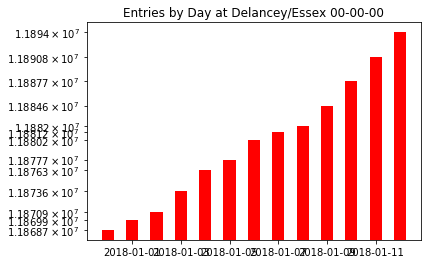

In [88]:
plt.bar(dfgraph['DATE'], dfgraph['ENTRIES'],
        width = .5,
        color = 'red',
        log = True,
        align = 'center'
       )

plt.yticks(dfgraph['ENTRIES']);
plt.title('Entries by Day at Delancey/Essex 00-00-00');

#### Challenge 5

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.  

We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [89]:
df6.columns

Index(['C/A', 'UNIT', 'SCP', 'LINENAME', 'STATION', 'DATE', 'ENTRIES',
       'PREV_DATE', 'PREV_ENTRIES'],
      dtype='object')

In [90]:
df6.nunique()


C/A               731
UNIT              464
SCP               203
LINENAME           95
STATION           373
DATE               13
ENTRIES         53564
PREV_DATE          13
PREV_ENTRIES    53542
dtype: int64

In [93]:
(df6.groupby(['LINENAME', 'STATION', 'UNIT','C/A'])
 ['ENTRIES'].sum().reset_index().head())

,LINENAME,STATION,UNIT,C/A,ENTRIES
0,1,103 ST,R191,R170,716900368
1,1,116 ST-COLUMBIA,R159,R173,15843377435
2,1,125 ST,R034,R174,8524450694
3,1,137 ST CITY COL,R169,R175,2551159107
4,1,137 ST CITY COL,R169,R176,667038718


#### Challenge 6

Similarly, combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.

In [96]:
(df6.groupby(['LINENAME', 'STATION', 'UNIT','C/A','DATE'])
 ['ENTRIES'].sum().reset_index().head())

,LINENAME,STATION,UNIT,C/A,DATE,ENTRIES
0,1,103 ST,R191,R170,2017-12-31,36227615
1,1,103 ST,R191,R170,2018-01-01,36234642
2,1,103 ST,R191,R170,2018-01-02,58534128
3,1,103 ST,R191,R170,2018-01-03,58545467
4,1,103 ST,R191,R170,2018-01-04,58557608


#### Challenge 7
Plot the time series for a station.

In [153]:
dfCU = (df6[df6.STATION == '116 ST-COLUMBIA']
        .groupby('DATE',as_index = False)
        .ENTRIES.sum())
dfCU.head()

,DATE,ENTRIES
0,2017-12-31,1218685291
1,2018-01-01,1218688388
2,2018-01-02,1218690807
3,2018-01-03,1218697258
4,2018-01-04,1218706533


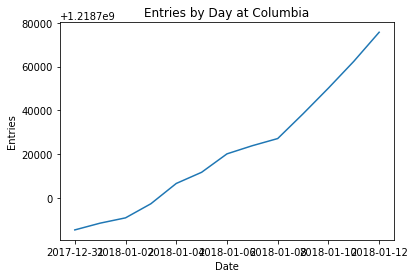

In [158]:
plt.plot(dfCU['DATE'],dfCU['ENTRIES'])

plt.xlabel('Date')
plt.ylabel('Entries')
plt.title('Entries by Day at Columbia');